## Imports

In [ ]:
# can be used to install archtype analysis
import sys
# !pip install py_pcha


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from pathlib import Path
import scipy.io
import py_pcha

import warnings
warnings.filterwarnings('ignore')

## Load dataset

In [3]:
path = Path().cwd()

data_path = path.parent / "Matlab" / "Data" / "Synthdata.mat"
mat = scipy.io.loadmat(data_path)

X = mat['X']

n, p = np.shape(X[0,0].T)

print(f'Number of datasets: {X.shape[1]}')
print(f'number of observations for each dataset:{n}, number of features: {p}')

Number of datasets: 6
number of observations for each dataset:1000, number of features: 2


## Helper Functions

In [4]:
def draw_vector(v0, v1, ax=None, rescale=True):

    dist = np.sqrt((v1[0]-v0[0])**2+(v1[1]-v0[1])**2)
    if rescale:
        v1[0] = v1[0]/dist
        v1[1] = v1[1]/dist
    
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

### 1 Inspect and run the script ex1.m . The script analyses various synthetically generated datausing the following unsupervised learning methods:SVD, NMF, Archetypical Analysis (AA), Sparse Coding (SC), Non-negative Sparse Coding(NSC), ICA, and K-means

In [ ]:
methods = ['SVD','NMF', 'AA', 'SC', 'NSC', 'ICA', 'kmeans']
lbda = .01 # L1 regularization strength for the methods SC and NSC



In [25]:
np.min(X + abs(np.min(X)))

0.0

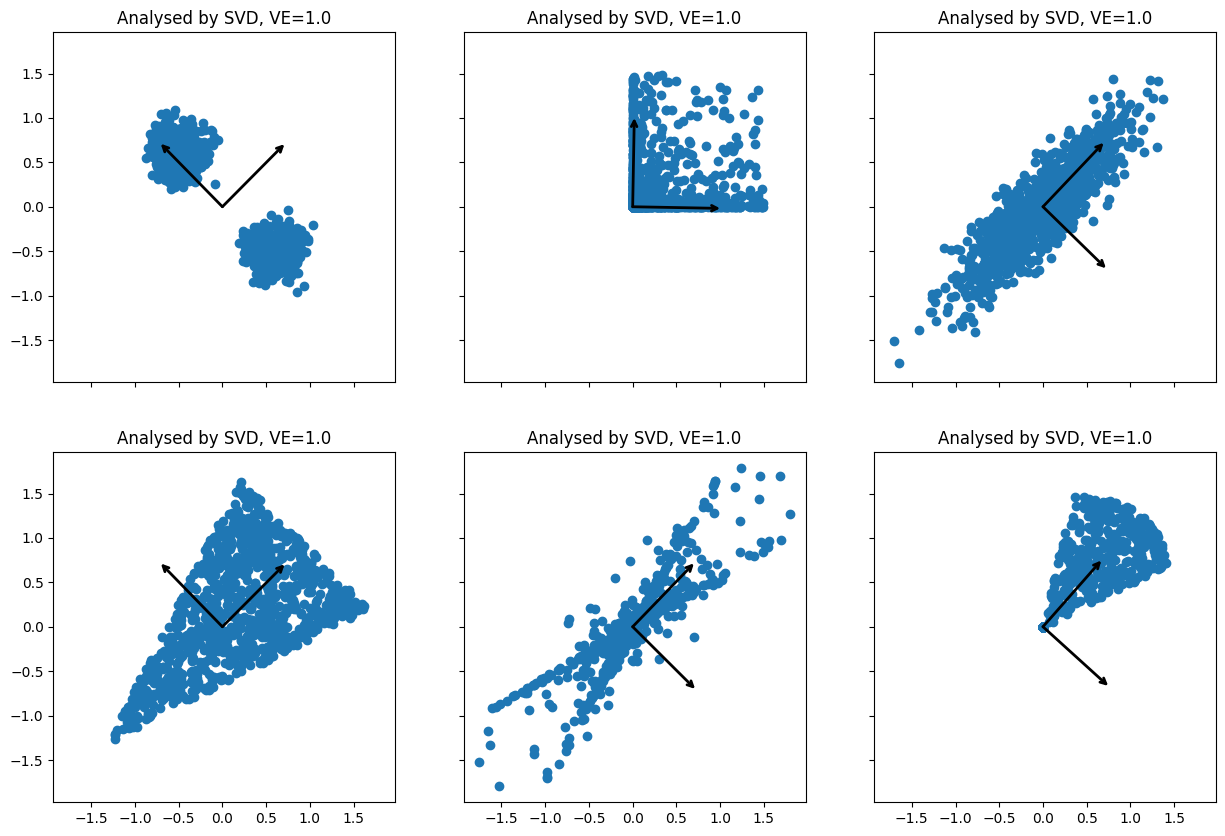

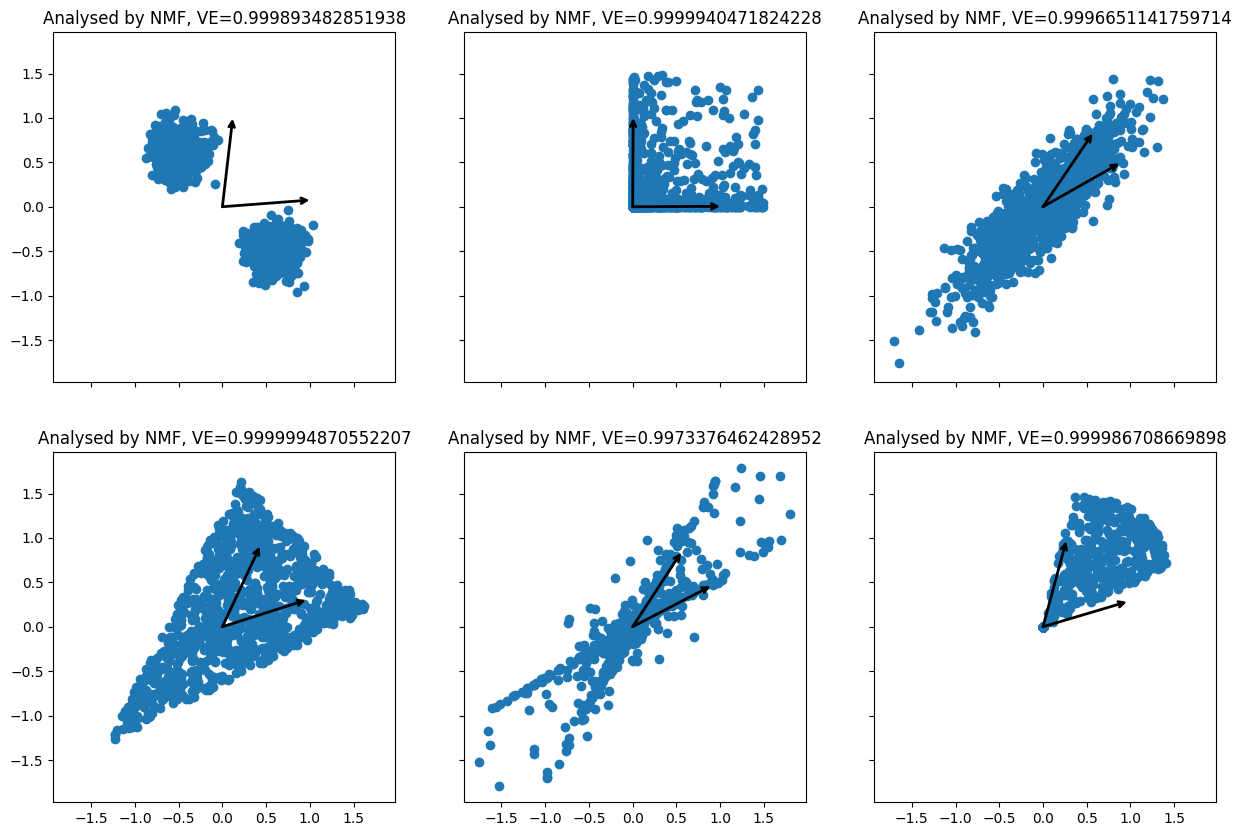

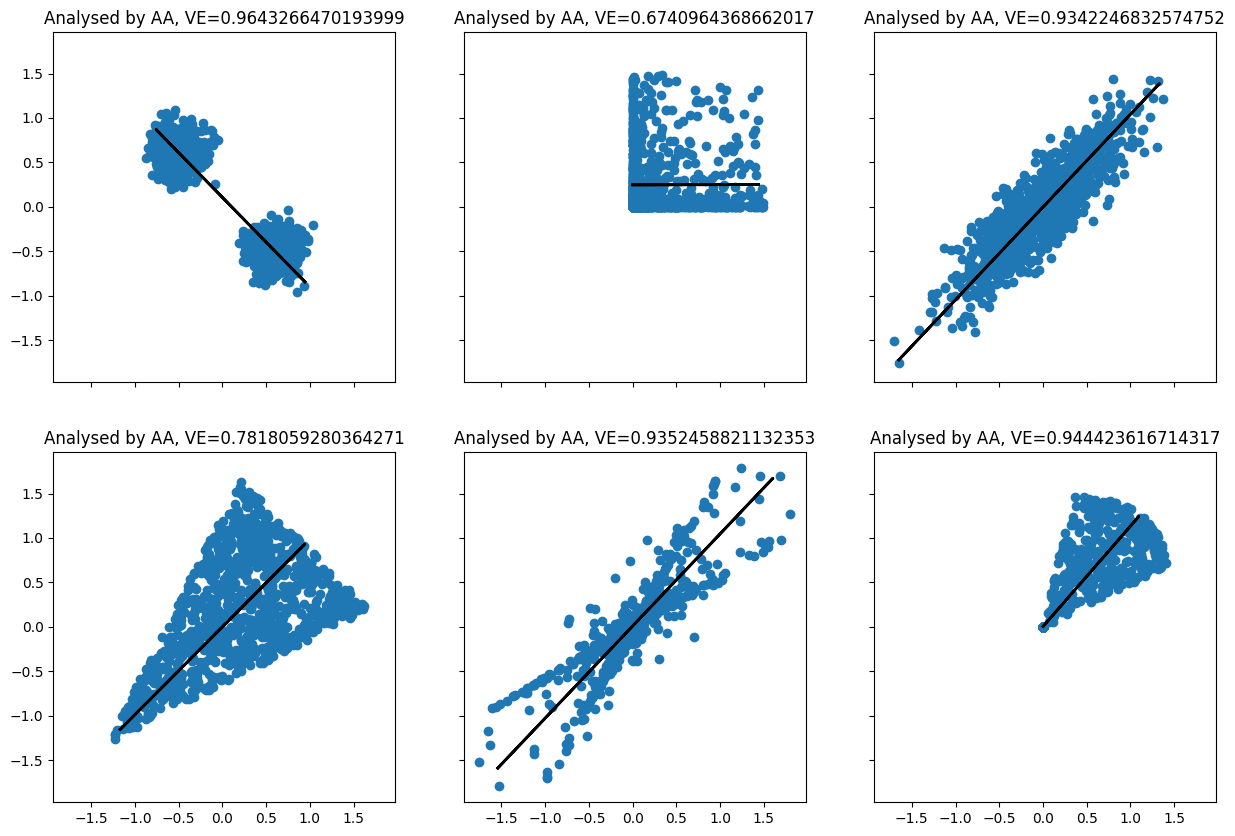

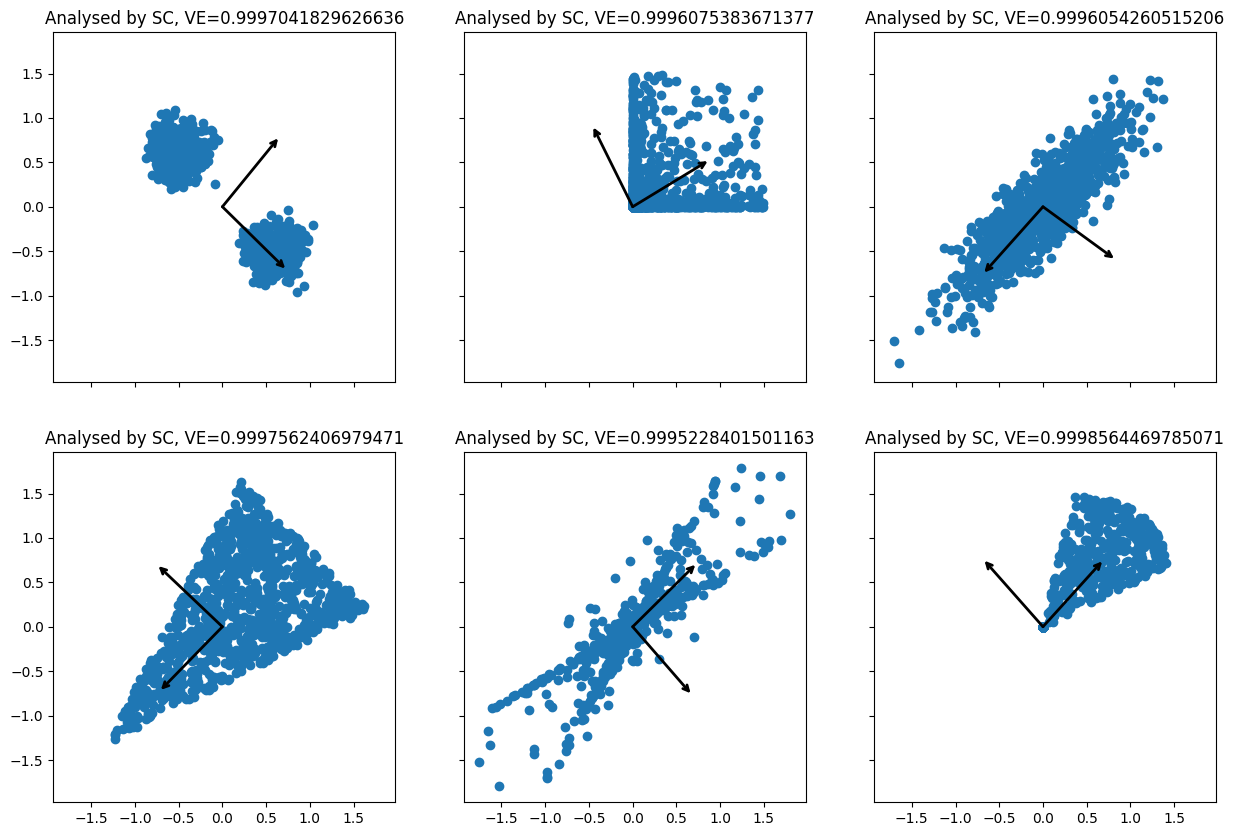

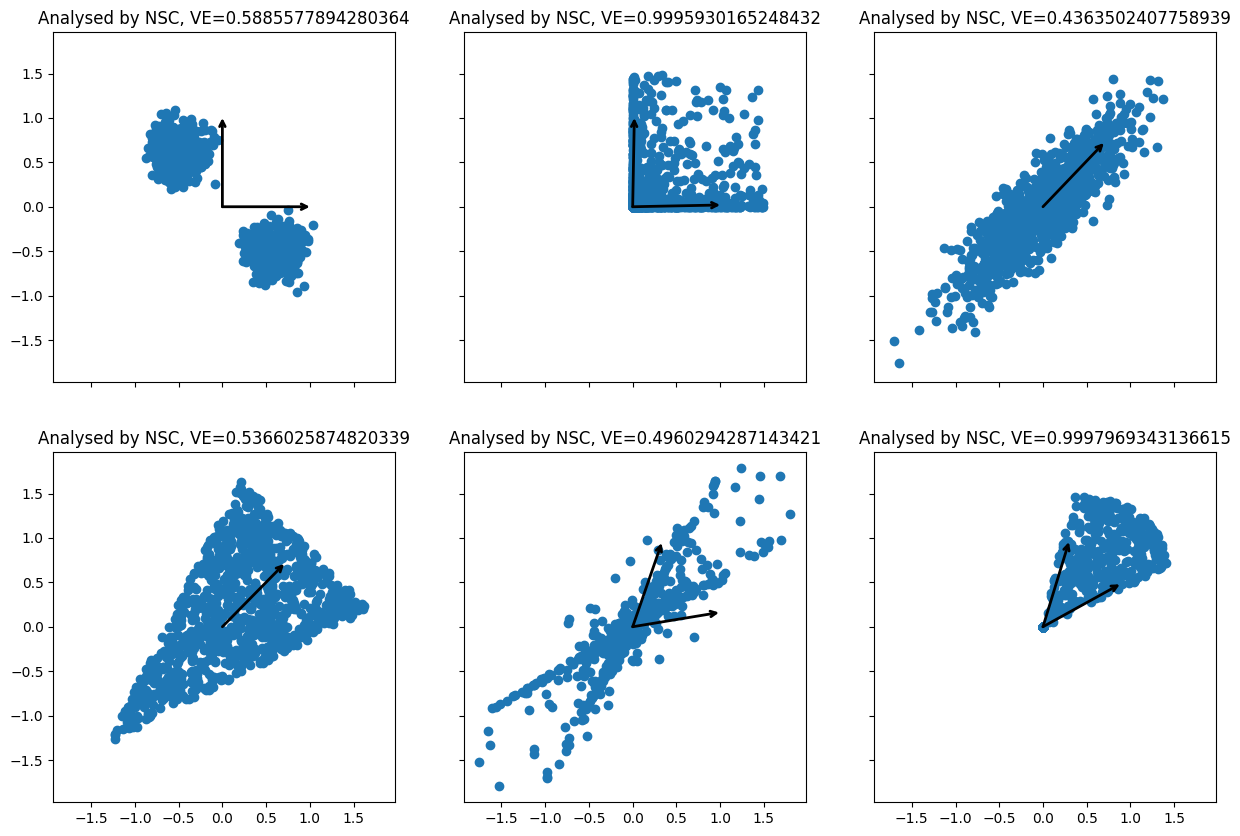

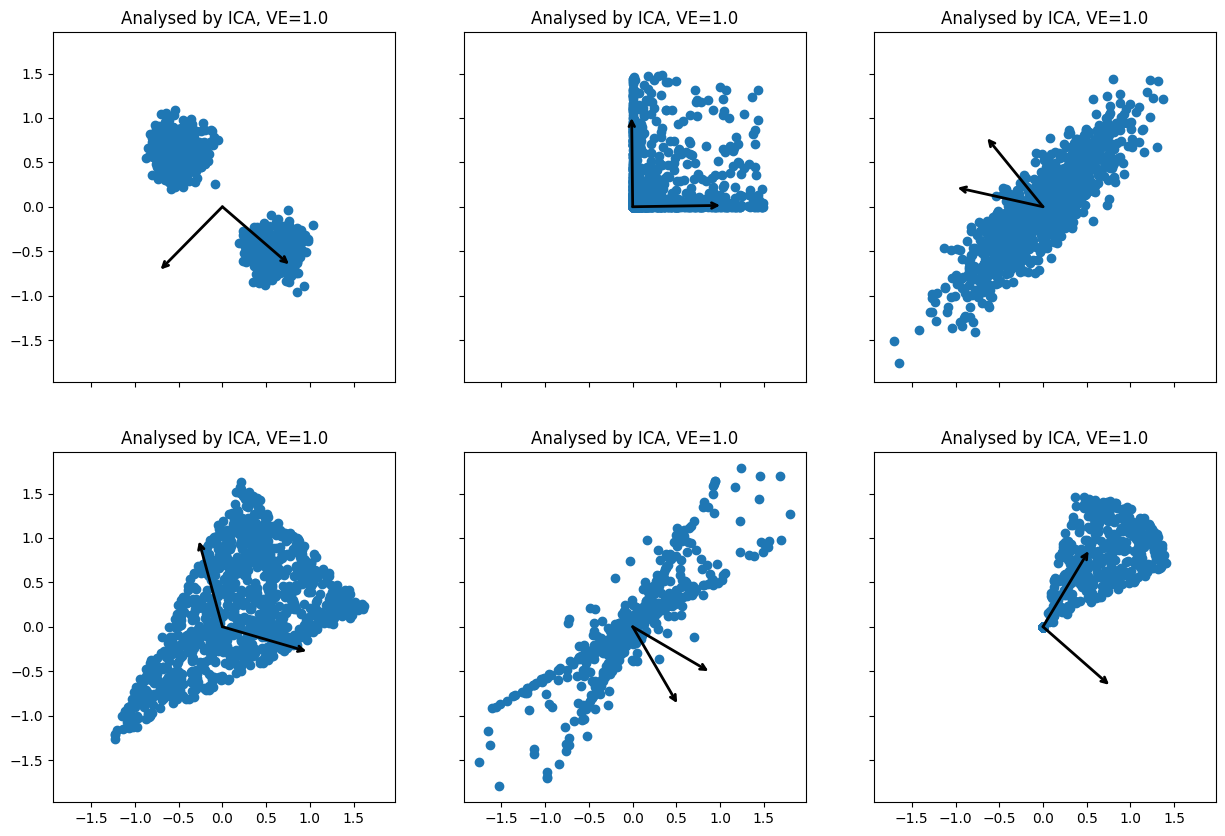

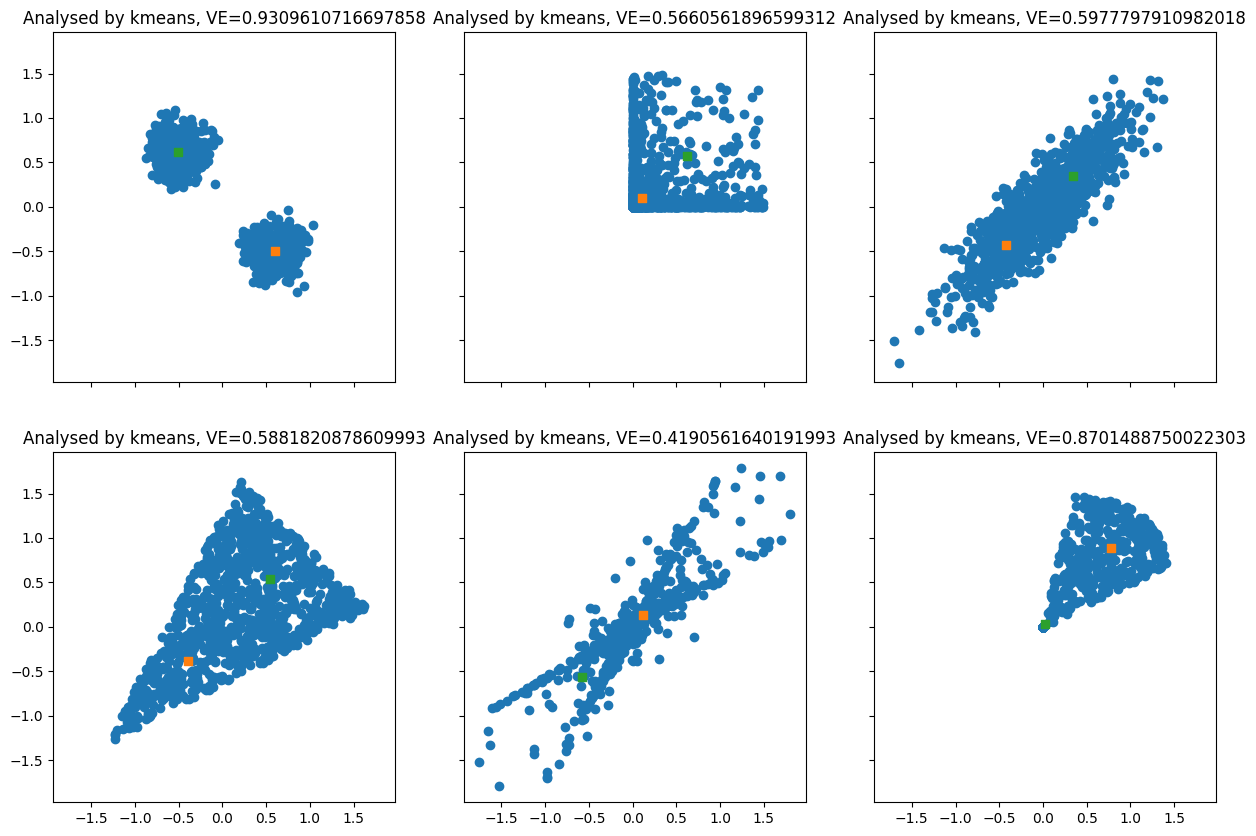

In [26]:
n_components = 2
# method = methods[3]

for method in methods:
    fig, ax = plt.subplots(2,3, figsize=(15,10),sharex=True, sharey=True)
    for k in range(6):
        X = mat['X'][0,k].T
        
        ax[k//3,k%3].scatter(X[:,0], X[:,1])

        SST = np.sum(X**2)
        L = np.nan
        if method == 'SVD':
            # centering of data is done in the PCA class
            model = decomposition.PCA(n_components=n_components)
            X_transformed = model.fit_transform(X)
            X_hat = X_transformed.dot(model.components_) + model.mean_
            L = 0.5*np.linalg.norm(X-X_hat)**2
            for length, vector in zip(model.explained_variance_, model.components_):
                v = vector * np.sqrt(length)
                draw_vector((0,0), v, ax[k//3,k%3])
        elif method == 'NMF':
            # if (len(np.where(X<0)[0])) == 0 :
            # Create model init method is set to random
            model = decomposition.NMF(n_components=n_components, init='random', random_state=0,solver='mu')
            # Fit NMF where W is loadings and H is Factors
            model.fit(X + abs(np.min(X)))
            L = 0.5*model.reconstruction_err_**2
            # print(model.components_)
            for component in model.components_:
                draw_vector((0,0), component, ax[k//3,k%3])
        elif method =='AA':
            XC, S, C, SSE, varexpl = py_pcha.PCHA(X.T, noc=n_components, delta=0.1)
            '''
                Output
                ------
                XC : numpy.2darray
                    I x noc feature matrix (i.e. XC=X[:,I]*C forming the archetypes)

                S : numpy.2darray
                    noc X n matrix, S>=0 |S_j|_1=1

                C : numpy.2darray
                    x x noc matrix, C>=0 |c_j|_1=1

                SSE : float
                    Sum of Squared Errors
            '''
            X_hat = X.T @ C @ S
            L = 0.5*np.linalg.norm(X.T-X_hat)**2
            
            X_plot = np.asarray(np.concatenate((XC, XC[:,0]),axis=1))
            ax[k//3,k%3].plot(X_plot[0,:],X_plot[1,:],'k-',linewidth=2)
        elif method == 'ICA':
            # Create model
            model = decomposition.FastICA(n_components=n_components,algorithm='parallel')
            X_transformed = model.fit_transform(X)
            X_hat = np.dot(X_transformed, model.mixing_.T) + model.mean_
            L = 0.5*np.linalg.norm(X-X_hat)**2
            for component in model.components_:
                # multiplication simply to make the components more visible
                draw_vector((0,0), component, ax[k//3,k%3])
        elif method == 'SC':
            # Create model n_iter = total number of iterations to perform
            # alpha is sparsity controlling parameter
            model = decomposition.DictionaryLearning(n_components=n_components, alpha=lbda, transform_alpha=lbda, max_iter=100, transform_max_iter=100, fit_algorithm='cd', transform_algorithm='lasso_cd')
            X_transformed = model.fit_transform(X)
            X_hat = X_transformed @ model.components_
            L = 0.5*np.linalg.norm(X-X_hat)**2
            for component in model.components_:
                draw_vector((0,0), component, ax[k//3,k%3])
        elif method == 'NSC':
            # Create model n_iter = total number of iterations to perform
            # alpha is sparsity controlling parameter
            model = decomposition.DictionaryLearning(n_components=n_components, positive_code=True, positive_dict=True, alpha=lbda, transform_alpha=lbda, max_iter=100, transform_max_iter=100, fit_algorithm='cd', transform_algorithm='lasso_cd')
            X_transformed = model.fit_transform(X)
            X_hat = X_transformed @ model.components_
            L = 0.5*np.linalg.norm(X-X_hat)**2
            for component in model.components_:
                draw_vector((0,0), component, ax[k//3,k%3])
        elif method == 'kmeans':
            # Create model tol controls early stopping, max_iter is max iterations over the entire dataset before stopping
            # Batch size controls batch Size of the mini batches.
            model =  KMeans(n_clusters=n_components)
            # Fit model with data
            model.fit(X)
            enc = preprocessing.OneHotEncoder(sparse_output=False)
            cluster_affiliation = enc.fit_transform(np.expand_dims(model.labels_,axis=1))
            X_hat = cluster_affiliation @ model.cluster_centers_
            L = 0.5*np.linalg.norm(X-X_hat)**2
            for component in model.cluster_centers_:
                ax[k//3,k%3].scatter(component[0],component[1],marker="s")

        # print(method)
        ax[k//3,k%3].set_title(f'Analysed by {method}, VE={1-2*L/SST}')              
    plt.show()